Dense wD aGP

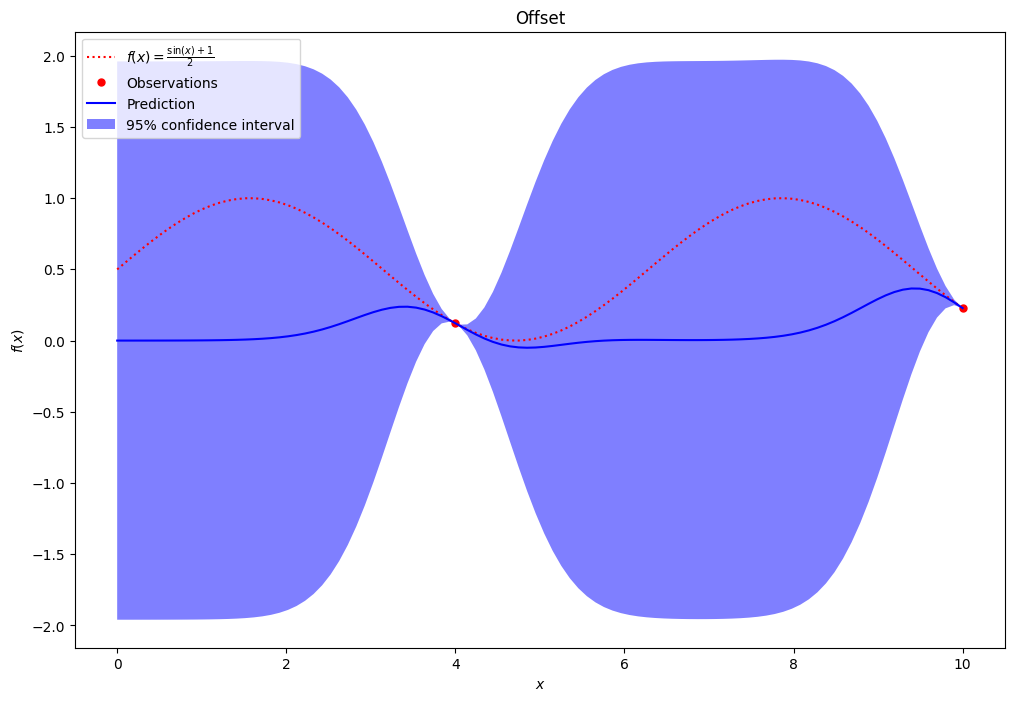

/tmp/ipykernel_4175470/1295672178.py:14: RuntimeWarning: divide by zero encountered in divide
  Z = imp / sigma.reshape(-1, 1)


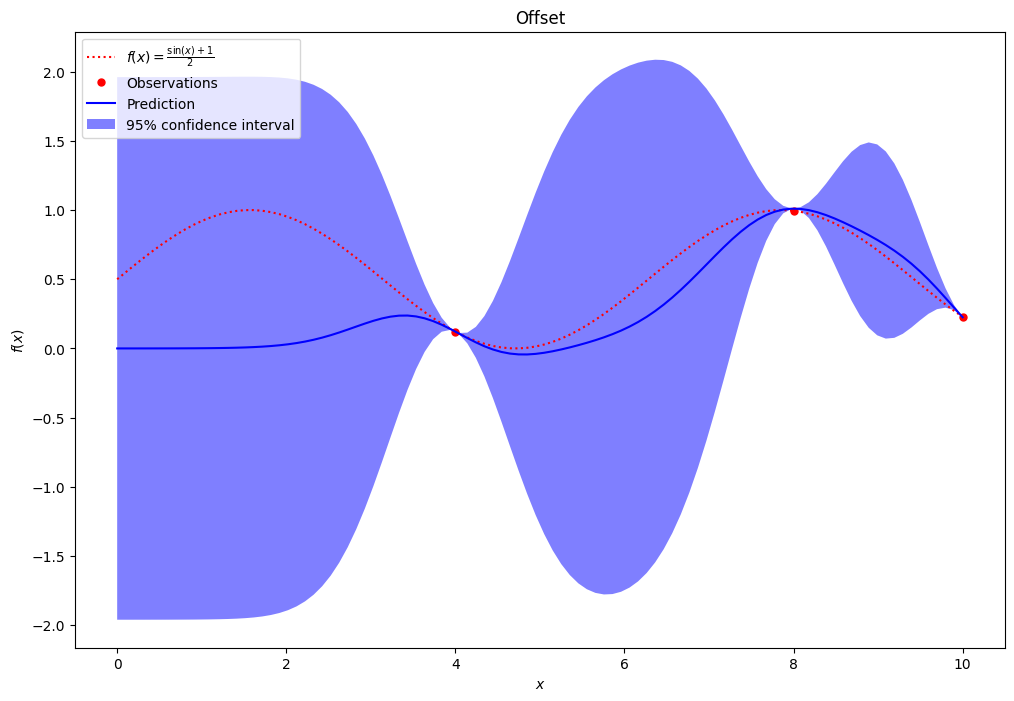

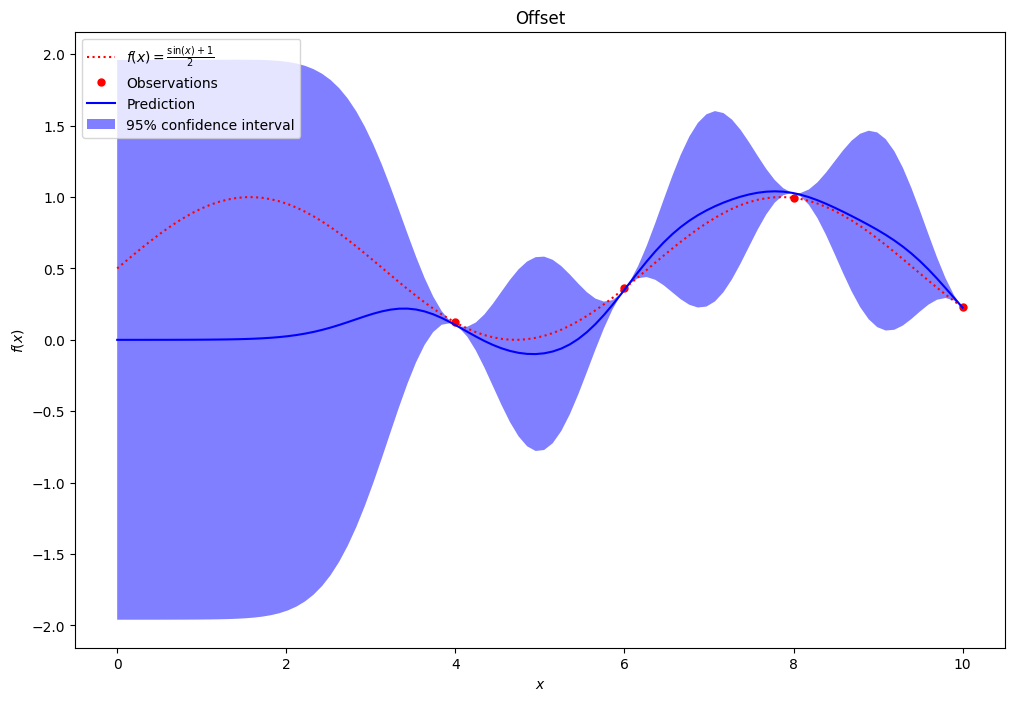

In [3]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

QUANTIZATION_FACTOR = 2
OFFSET_RANGE = 1
OFFSET_SCALE = 1
n_iterations = 2
np.random.seed(42)
INTERVAL = 10

def expected_improvement(X, mu, sigma, xi=0.01):
    imp = mu.reshape(-1, 1) - np.max(mu) - xi
    Z = imp / sigma.reshape(-1, 1)
    ei = imp * norm.cdf(Z) + sigma.reshape(-1, 1) * norm.pdf(Z)
    ei[sigma == 0.0] = 0.0
    return ei

def kernel(a, b, l=1.0):
    return np.exp(-0.5 * ((a - b)**2 / l**2))

def f(x):
    return (np.sin(x) + 1) / 2

def x_discrete(x):
    return np.round(x / QUANTIZATION_FACTOR) * QUANTIZATION_FACTOR

def f_discrete(x):
    return f(x)

def offset_scalar(x):
    return np.cos(x)/2

def offset_function(x_train, x_test, offset_scalar_func, offset_range, offset_scale):
    a = offset_scale * offset_scalar_func(x_train)
    return np.array([sum([a_i * ((x_i - mu_i) / offset_range) * np.exp(-((x_i - mu_i) / offset_range) ** 2) for mu_i, a_i in zip(x_train, a)]) for x_i in x_test])


def compute_K(x_train, kernel_func):
    return np.array([[kernel_func(x_i.item(), x_j.item()) for x_j in x_train] for x_i in x_train])

def compute_K_star(x_train, x_test, kernel_func):
    return np.array([[kernel_func(x_i.item(), x_j.item()) for x_j in x_train] for x_i in x_test])

def compute_var_star(x_test, K_star, K, kernel_func):
    return np.array([kernel_func(x_i.item(), x_i.item()) - K_star_i @ np.linalg.inv(K) @ K_star_i.T for x_i, K_star_i in zip(x_test, K_star)])

def predict_and_plot(x_train, y_train, x_test, kernel, f, offset_range=3.0, offset_scale=1.0):
    K = compute_K(x_train, kernel)
    K_star = compute_K_star(x_train, x_test, kernel)
    offsetkernel = offset_function(x_train, x_test, offset_scalar, offset_range, offset_scale)
    mu_star = K_star @ np.linalg.inv(K) @ y_train.flatten() + offsetkernel.flatten()
    var_star = compute_var_star(x_test, K_star, K, kernel)

    plt.figure(figsize=(12, 8))
    plt.plot(x_test, f_discrete(x_test), 'r:', label=r'$f(x) = \frac{\sin(x) + 1}{2}$')
    plt.plot(x_train, y_train, 'r.', markersize=10, label='Observations')
    plt.plot(x_test, mu_star, 'b-', label='Prediction')
    plt.fill(np.concatenate([x_test, x_test[::-1]]),
             np.concatenate([mu_star - 1.9600 * var_star,
                             (mu_star + 1.9600 * var_star)[::-1]]),
             alpha=.5, fc='b', ec='None', label='95% confidence interval')
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')
    plt.legend(loc='upper left')
    plt.title("Offset")
    plt.show()

    return mu_star, var_star

x_train = x_discrete(np.random.uniform(0, INTERVAL, 2).reshape(-1, 1))
y_train = f_discrete(x_train)
x_test = np.linspace(0, INTERVAL, 100).reshape(-1, 1)

mu_star, var_star = predict_and_plot(x_train, y_train, x_test, kernel, f, offset_range=OFFSET_RANGE, offset_scale=OFFSET_SCALE)

for iteration in range(n_iterations):
    EI = expected_improvement(x_test, mu_star.reshape(-1, 1), var_star.reshape(-1, 1), xi=0.01)
    x_next = x_discrete(x_test[np.argmax(EI)])
    y_next = f_discrete(x_next)
    x_train = np.vstack((x_train, x_next))
    y_train = np.vstack((y_train, y_next))

    mu_star, var_star = predict_and_plot(x_train, y_train, x_test, kernel, f, offset_range=OFFSET_RANGE, offset_scale=OFFSET_SCALE)


3D

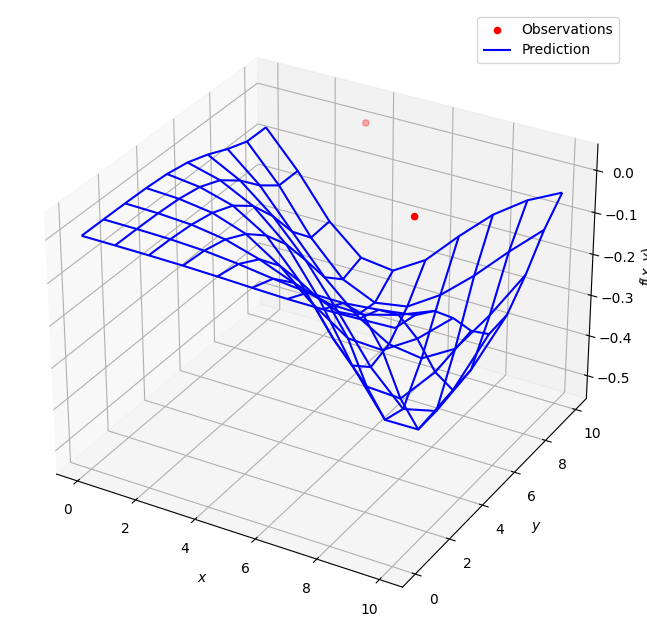

In [15]:
import numpy as np
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

QUANTIZATION_FACTOR = 2
OFFSET_RANGE = 1
OFFSET_SCALE = 1
n_iterations = 0
np.random.seed(42)
INTERVAL = 10

def expected_improvement(X, mu, sigma, xi=0.01):
    imp = mu.reshape(-1) - np.max(mu) - xi
    Z = imp / sigma.reshape(-1)
    ei = imp * norm.cdf(Z) + sigma.reshape(-1) * norm.pdf(Z)
    ei[sigma == 0.0] = 0.0
    return ei

def kernel(a, b, l=1.0):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * sqdist / l**2)

def f(x, y):
    z = (np.sin(5*x) * np.cos(5*y)) / 5
    z_min = 0  # Minimum value of z in the range [-1, 1]
    z_max = 1   # Maximum value of z in the range [-1, 1]

    # Normalize z to the range [0, 1]
    z_normalized = (z - z_min) / (z_max - z_min)
    return z_normalized

def x_discrete(x):
    return np.round(x / QUANTIZATION_FACTOR) * QUANTIZATION_FACTOR

def f_discrete(x, y):
    return f(x, y)

def offset_scalar(x):
    return np.cos(np.sqrt(np.sum(x**2, axis=1)))/2

def offset_function(x_train, x_test, offset_scalar_func, offset_range, offset_scale):
    a = offset_scale * offset_scalar_func(x_train)
    res = np.zeros(x_test.shape[0])
    for i, x_i in enumerate(x_test):
        for j, mu_i in enumerate(x_train):
            res[i] += a[j] * np.exp(-np.sum((x_i - mu_i)**2) / offset_range ** 2)
    return res


def predict(x_train, y_train, x_test, kernel, offset_range=3.0, offset_scale=1.0):
    K = kernel(x_train, x_train)
    K_star = kernel(x_test, x_train)
    offsetkernel = offset_function(x_train, x_test, offset_scalar, offset_range, offset_scale)
    mu_star = K_star @ np.linalg.inv(K) @ y_train.flatten() + offsetkernel.flatten()
    var_star = np.diag(kernel(x_test, x_test) - K_star @ np.linalg.inv(K) @ K_star.T)
    return mu_star, var_star

x_train = np.random.uniform(0, INTERVAL, (2, 2))
y_train = f_discrete(x_train[:,0], x_train[:,1])
x_test = np.stack([x.reshape(-1) for x in np.meshgrid(np.linspace(0, INTERVAL, 10), np.linspace(0, INTERVAL, 10))]).T

mu_star, var_star = predict(x_train, y_train, x_test, kernel)

for iteration in range(n_iterations):
    EI = expected_improvement(x_test, mu_star, var_star, xi=0.01)
    x_next = x_discrete(x_test[np.argmax(EI)])
    x_next = x_next.reshape(1, -1)  # Ensure x_next is a 2D array
    y_next = f_discrete(x_next[:,0], x_next[:,1])
    x_train = np.vstack((x_train, x_next))
    y_train = np.hstack((y_train, y_next))

    mu_star, var_star = predict(x_train, y_train, x_test, kernel)


# Plotting
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train[:, 0], x_train[:, 1], y_train, c='r', label='Observations')

x1_test = x_test[:, 0].reshape(10, 10) # Reshape x_test for the first dimension
x2_test = x_test[:, 1].reshape(10, 10) # Reshape x_test for the second dimension
mu_star_surface = mu_star.reshape(10, 10) # Reshape mu_star

# Replace ax.plot_surface with ax.plot_wireframe for better visualization
ax.plot_wireframe(x1_test, x2_test, mu_star_surface, color='b', label='Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$f(x, y)$')
ax.legend()
plt.show()



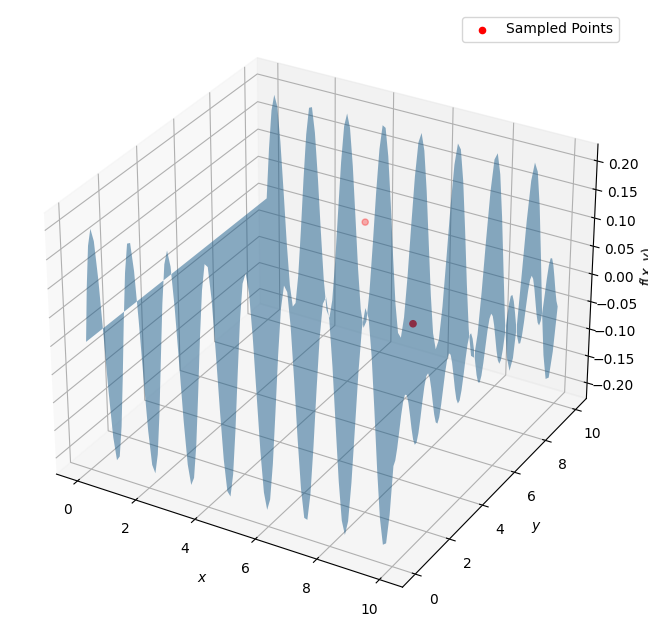

In [16]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Objective function surface
x1 = np.linspace(0, INTERVAL, 100)
x2 = np.linspace(0, INTERVAL, 100)
x1_grid, x2_grid = np.meshgrid(x1, x2)
y_grid = f(x1_grid, x2_grid)
ax.plot_surface(x1_grid, x2_grid, y_grid, alpha=0.5, rstride=100, cstride=100)

# Sampled points
ax.scatter(x_train[:, 0], x_train[:, 1], y_train, c='red', label='Sampled Points')

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$f(x, y)$')
ax.legend()
plt.show()


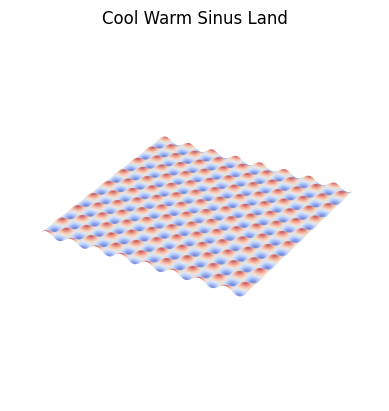

In [7]:
# import necessary libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

# container "fig" for the plot(s, it's actually one^^)
fig = plt.figure(figsize=plt.figaspect(1), dpi=100) # change dpi to smaller value

# cartesian coordinate system (the standard one)
x = np.linspace(-5, 5, endpoint=True, num=1000)
y = np.linspace(-5, 5, endpoint=True, num=1000)
x, y = np.meshgrid(x, y)
z = (np.sin(5*x)*np.cos(5*y))/5 # the mathematical function f(x,y) = z

# Add a plot to the container (figure)
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=True, rstride=2, cstride=2)
ax.set_title('Cool Warm Sinus Land') # change title

# scaling of the shown function
lim = (max(abs(max(np.max(x), np.max(y), np.max(z))), abs(min(np.min(x), np.min(y), np.min(z)))))
# Set the axis limits
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_zlim(-lim, lim)

# deactivate coordinate axis rendering
ax.axis('off')

plt.show()


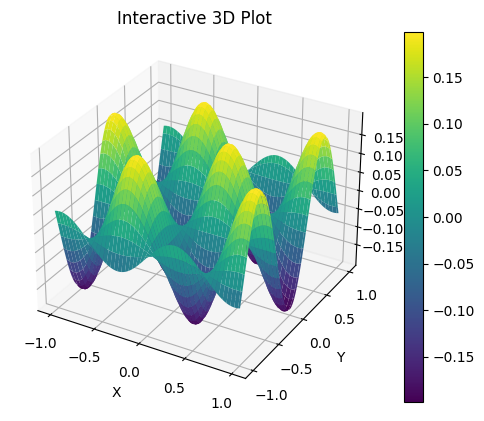

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the function
def f(x, y):
    z = (np.sin(5*x) * np.cos(5*y)) / 5
    z_min = 0  # Minimum value of z in the range [-1, 1]
    z_max = 1  # Maximum value of z in the range [-1, 1]

    # Normalize z to the range [0, 1]
    z_normalized = (z - z_min) / (z_max - z_min)
    return z_normalized

# Generate data
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

# Create the figure and axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# Add a colorbar
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Interactive 3D Plot')

# Show the plot
plt.show()
